<a href="https://colab.research.google.com/github/nicovakr/Pytorch-init/blob/master/DeepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Network on GPU

In [1]:
import numpy as np
import matplotlib
import torch
import torchvision
import torchaudio

In [2]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

#white background for figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# download & create PyTorch dataset using MNIST class from torchvision.datasets
dataset = MNIST(root='data/', download = True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



image.shape: torch.Size([1, 28, 28])
Label: 5


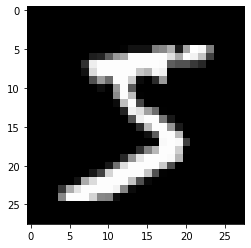

In [4]:
# image converted to Pytorch tensors w the shape 1x28x28 : color(x)width(x)height
# plt.imshow expects channels to be last dimension in an image tensor
# => use permute or np.squeeze to reorder dimensions of the image
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(np.squeeze(image), cmap='gray')
# np.squeeze(image) ou image.permute(1, 2, 0)
print('Label:', label)

In [5]:
# split dataset into training and validation dataset 
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

In [7]:
# create Pytorch data loaders for training and validation

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
# num_workers : number of subprocesses to use for data loading
#               if zero = data loaded in the main process
# pin_memory : True => the data loader will copy Tensors intpo CUDA pinned memory before returning them

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


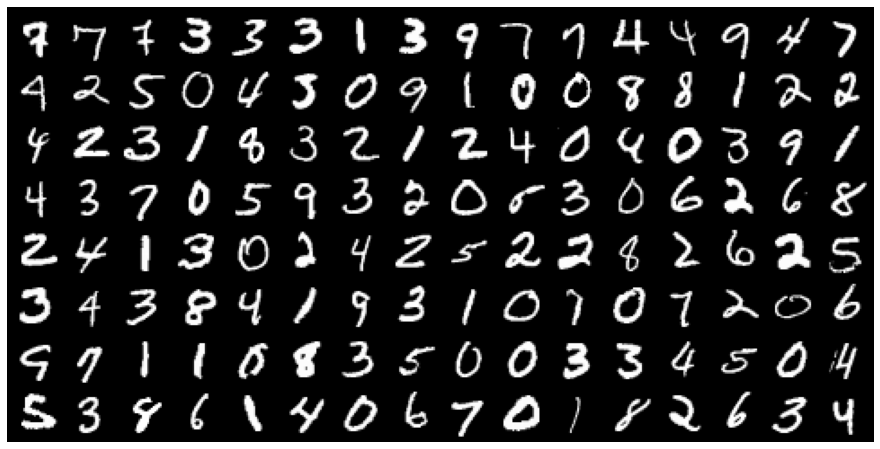

In [8]:
# visualizing a batch of data in a grid

for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

## Hidden layers, Activation functions and Non-linearity

Create a neural network with two layers : a hidden layer and an output layer.

We will add an activation function between the two layers.

In [9]:
# Create a batch of inputs tensors : 
# we must flatten the 1x28x28 images into vectors of size 784
#     to be passed into a nn.Linear object

for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape:', inputs.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [10]:
# Create a nn.Linear object which will serve as our hidden layer
# set the size of the output from the hidden layer to 32 
#       : can be increased or decreased to change the Learning Capacity of model

input_size = inputs.shape[-1]
hidden_size = 32 # learning capacity of the model

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [14]:
layer1.bias.shape

torch.Size([32])

In [15]:
# inputs{128x784}
# layer1weight{32x784}
# layer1bias{32}
# {128x784} @ tr({32x784}) + {32}
# = {128x32}
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [16]:
# torch.allclose (input, other, relative_tolerance) -> BOOLEAN
# torch.allclose checks if inputs and other satisfy the condition :
# abs|input - compared| =< rel_tolerance * abs|other|
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [17]:
# layer1_outputs et inputs have a linear relationship : 
# => each element of layer1_outputs is a weighted sum of elements from inputs

In [18]:
# Activation function for the outputs : ReLU
# Rectified Linear Unit
# relu(x) = max(0,x)
# it simply replaces negative valuers in a given tensor with the value 0
# it is a non-linear function

F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [19]:
# apply the activation function to layer1_outputs and verifiy that negatives values
# were replaced with 0
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.8097645044326782
min(relu_outputs): 0.0


In [20]:
# we have applied a non linear function
# relu_outputs and inputs do not have a linear relationship

# We refer to ReLU as the activation function beacause for each input
# certain outputs are activated (those with non-zero value) 
#       while others turned off (those with zero value)

In [21]:
# Create an output layer to convert vectors of length hidden_size in relu_outputs 
# into vectors of length 10 
# which is the desired output of our model (10 target labels)

output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [22]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [23]:
inputs.shape

torch.Size([128, 784])

In [24]:
# we can use the layer2_outputs to compute the loss using F.cross_entropy
# and adjust the weights of layer1 and layer2 using SGD
F.cross_entropy(layer2_outputs, labels)

tensor(2.3026, grad_fn=<NllLossBackward0>)

In [25]:
# OUT = ( f(X x tr(W1) + b1) x tr(W2) + b2 )
# with : f the relu function
#        X the inputs {128,784}
#        W1 the layer1.weights {32,784}
#        b1 the layer1.bias {32}
#        W2 the layer2.weights {10,32}
#        b2 the layer2.bias {10}
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [26]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Outputs and inputs do not have linear relationship due to the non-linear activation function. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationship between the images and their labels.

In other words, introducing non-linearity makes the model more powerful and versatile. Also since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.


In [27]:
# Test without the non-linearity 
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [28]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)
#                         ({128,784}  ,   {10})
combined_layer.weight.shape, combined_layer.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [29]:
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [30]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [31]:
torch.allclose(outputs2, outputs3, 1e-3)

True

#Model

In [31]:
# Create a NN with one hidden layer

# instead of using a single nn.Linear object to transform a batch of inputs into outputs (class probabilities)
#   we will use two nn.Linear objects : each of these is called a layer in the network

# First layer (hidden layer) will transform the input matrix of shape {batch_size, 28x28}
#   into an intermediate output matrix of shape {batch_size, hidden_size}
#   the parameter hidden_size can be configured manually (eg 32 or 64)

# We will apply a non linear activation function to the intermediate outputs
#   the act function transforms individual elements of the matrix

# the results of the activation function, which is also of size {batch_size, hidden_size}
#   is passed into the second layer (output layer)
#   the second layer transforms into a matrix of size {batch_size, 10}
#   we can use this output to compute the loss and adjust weights using SGD

In [80]:
class MnistModel(nn.Module):
  """Feedforward neural network with 1 hidden layer"""

  def __init__(self, in_size, hidden_size, out_size):
    # super() allow the class to inherit all the methods and properties from torch.nn.Module class from PyTorch
    super().__init__()

    # hidden layer with dimensions
    self.linear1 = nn.Linear(in_size, hidden_size)

    # output layer with dimensions
    self.linear2 = nn.Linear(hidden_size, out_size)

  
  def forward(self, xb):

    # flatten the image tensors
    # image from torch.Size([1, 28, 28]) to torch.Size([1, 784])
    xb = xb.view(xb.size(0), -1)

    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)

    # Apply activation function
    out = F.relu(out)

    # Get predictions using output layer
    out = self.linear2(out)

    return out

  
  def training_step(self, batch):
    # take info from batch (<image>, label)
    images, labels = batch

    # Generate predictions
    out = self(images)

    # Calculate Loss
    loss = F.cross_entropy(out, labels)

    return loss


  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    
    # Calculate accuracy
    acc = accuracy(out, labels)

    return {'val_loss' : loss, 'val_acc': acc}


  def validation_epoch_end(self, outputs):

    batch_losses = [x['val_loss'] for x in outputs]

    # t = (tensor([1, 2, 3]), tensor([6, 60, 600]), tensor([5, 5, 5]))
    # torch.stack(t) = tensor([[1, 2, 3], [6, 60, 600], [5, 5, 5]])
    # torch.stack(t).mean() = mean on all values of t
    epoch_loss = torch.stack(batch_losses).mean()

    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()

    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [75]:
# Define accuracy which calculates the accuracy of the model's prediction on an batch of inputs
def accuracy(outputs, labels):
  # dim = 1 : max per row
  # _ : the max value
  # preds = index of the max : refers to the label predicted
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [81]:
# We will create a model that contains a hidden layer with 32 activations
input_size = 784
hidden_size = 32
num_classes = 10

In [82]:
model = MnistModel(input_size, hidden_size = 32, out_size = num_classes)

In [83]:
# take a look at model's parameters : weight and bias
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [84]:
# Generate outputs using the model
# take the first batch of 128 images from our dataset and pass them into model

for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('output.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.300135850906372
output.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0692,  0.0088, -0.0631, -0.0863,  0.0356, -0.0532,  0.0731, -0.0624,
          0.1316, -0.0423],
        [ 0.0145,  0.0087, -0.0570, -0.0892,  0.0571, -0.0199,  0.1153, -0.1127,
          0.1784, -0.0258]])


# Using a GPU

In [88]:
torch.cuda.is_available()

False

In [86]:
# helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it is not

def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [87]:
device = get_default_device()
device

device(type='cpu')

In [89]:
# function that can move data and model to a chosen device

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [90]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cpu


In [91]:
# class to wrap our existing data loaders and move batches of data to the selected device
# we do not need to extend an existing class to create a PyTorch data loader
# all we need is an __iter__ method to retrieve batches of data and a __len__ method to get the number of the batches

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""

  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      # yield is used to create a generator function that can be used within a for loop
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [92]:
# example for yield
def some_numbers():
  yield 10
  yield 20
  yield 30

for value in some_numbers():
  print(value)

10
20
30


In [93]:
# we can now wrap our data loaders using Device Data Loader

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [94]:
# Tensors moved to the GPU have a device property which includes that word cuda
# let us verify this by looking at a batch of data from valid_ld

for xb, yb in val_loader:
  print('xb.device:', xb.device)
  print('yb:', yb)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cpu
yb: tensor([1, 4, 8, 0, 9, 1, 6, 4, 2, 3, 7, 9, 9, 7, 0, 7, 4, 4, 2, 1, 0, 9, 8, 8,
        8, 9, 2, 7, 4, 3, 8, 7, 2, 3, 8, 4, 7, 4, 8, 1, 5, 2, 6, 1, 0, 8, 9, 0,
        0, 5, 6, 1, 1, 2, 8, 2, 5, 1, 3, 2, 6, 6, 0, 5, 7, 2, 7, 3, 6, 7, 7, 9,
        2, 9, 2, 5, 3, 2, 9, 0, 4, 3, 6, 2, 2, 4, 0, 0, 1, 5, 0, 2, 4, 1, 3, 6,
        4, 4, 4, 9, 5, 0, 3, 4, 7, 5, 1, 4, 6, 5, 7, 2, 0, 6, 1, 6, 8, 7, 2, 0,
        1, 1, 7, 2, 4, 1, 1, 1, 6, 7, 1, 7, 4, 2, 5, 8, 5, 5, 5, 0, 8, 4, 0, 9,
        7, 2, 3, 4, 4, 4, 3, 3, 8, 2, 0, 3, 3, 0, 2, 0, 2, 7, 9, 7, 2, 5, 0, 4,
        1, 8, 8, 1, 3, 9, 3, 3, 8, 8, 1, 0, 8, 2, 7, 8, 7, 9, 8, 8, 7, 2, 8, 9,
        8, 9, 2, 7, 2, 6, 3, 3, 7, 1, 8, 2, 5, 5, 4, 3, 4, 7, 5, 8, 9, 7, 5, 6,
        3, 3, 4, 5, 3, 3, 9, 7, 8, 6, 5, 8, 5, 0, 5, 7, 3, 8, 1, 1, 1, 5, 7, 2,
        8, 4, 1, 2, 9, 3, 4, 4, 9, 7, 8, 3, 5, 4, 7, 8])


# Training the model

In [95]:
# will define functions 'fit' and 'evaluate' to train the model using SGD 
# and evaluate performance on the validation set

def evaluate(model, val_loader):
  """Evaluate the models performance onthe validation set"""
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  """Train the model using gradient descent"""
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):

    # training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

In [96]:
# we need to ensure that data and models parameters (W and b) are on the same device
# we can reuse 'to_device' to move models parameters to right device
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [97]:
# see how model performs on the validation set with initial set of weight and bias
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09062500298023224, 'val_loss': 2.3017067909240723}]

In [98]:
# initial accuracy is about 9%
# train the model for 5 epochs
# lr = 0.5 relatively high
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.2462, val_acc: 0.9281
Epoch [1], val_loss: 0.1771, val_acc: 0.9472
Epoch [2], val_loss: 0.1673, val_acc: 0.9496
Epoch [3], val_loss: 0.1433, val_acc: 0.9603
Epoch [4], val_loss: 0.1638, val_acc: 0.9523


In [99]:
# 95% accuracy : good 
# train for 5 more epoch, lr=0.1 to improve accuracy further
history += fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.1218, val_acc: 0.9660
Epoch [1], val_loss: 0.1198, val_acc: 0.9660
Epoch [2], val_loss: 0.1186, val_acc: 0.9659
Epoch [3], val_loss: 0.1179, val_acc: 0.9676
Epoch [4], val_loss: 0.1170, val_acc: 0.9667


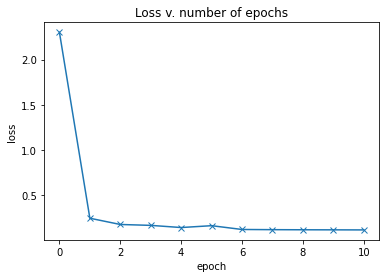

In [106]:
# we can plot the losses & accuracies to study how the model improves over time

losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss v. number of epochs');


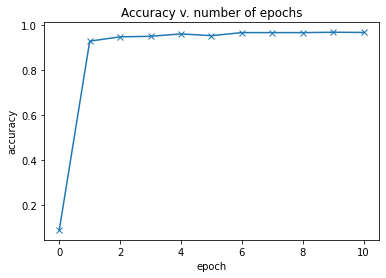

In [107]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy v. number of epochs');